# Beer Recommender System: Data Exploration and Preprocessing

This notebook represents the foundational phase of a hybrid beer recommender system project. The primary objective at this stage is to perform exploratory data analysis and preprocessing in preparation for building both collaborative filtering and content-based recommendation models using deep learning techniques.

## Dataset Source
The dataset utilized in this project is publicly available on Kaggle:  
**Beers, Breweries, and Beer Reviews**  
Link: [https://www.kaggle.com/datasets/ehallmar/beers-breweries-and-beer-reviews](https://www.kaggle.com/datasets/ehallmar/beers-breweries-and-beer-reviews)

It comprises the following components:
- `beers.csv`: Provides metadata for each beer, including style, alcohol by volume (ABV), and availability information.
- `breweries.csv`: Contains details about breweries, such as their geographical location and operational type.
- `reviews.csv`: Consists of more than 2 million user-submitted reviews, featuring numerical ratings, review text, user IDs, and timestamps.

## Objective of This Notebook
The aim of this notebook is to:
- Load and verify the integrity of the raw data
- Clean and filter out incomplete or inconsistent records
- Merge datasets to create a unified structure for analysis
- Engineer a cleaned dataset tailored for recommendation modeling
- Extract preliminary insights related to user behavior and beer popularity

The outputs generated in this phase are intended to support the development and evaluation of both collaborative and content-driven recommendation strategies in later stages of the project.


## Loading Datasets

The dataset comprises three primary CSV files, each of which is imported into a pandas DataFrame for further analysis:

- **`beers.csv`**: Contains metadata for individual beers, including their name, style, alcohol by volume (ABV), availability status, and descriptive notes.
- **`breweries.csv`**: Includes information about each brewery, such as its name, geographic location (city, state, country), and type (e.g., brewery, bar, store).
- **`reviews.csv`**: A substantial dataset with over 9 million user-generated reviews. Each entry features ratings for five sensory attributes (look, smell, taste, feel, overall), accompanying review text, the reviewer’s username, and a timestamp.

The datasets are read using `pandas.read_csv()` with UTF-8 encoding. The `low_memory=False` flag is applied to ensure reliable type inference, particularly given the file size of the reviews dataset. Upon successful loading, representative samples from each DataFrame are printed to confirm the structure and contents.


In [1]:
import pandas as pd

# File paths
beers_file = "beers.csv"
breweries_file = "breweries.csv"
reviews_file = "reviews.csv"

# Load Beers Data
try:
    beers = pd.read_csv(beers_file, encoding="utf-8", low_memory=False)
    print("\nBeers Data Sample:")
    print(beers.head())
except Exception as e:
    print(f"Error loading beers.csv: {e}")

# Load Breweries Data
try:
    breweries = pd.read_csv(breweries_file, encoding="utf-8", low_memory=False)
    print("\nBreweries Data Sample:")
    print(breweries.head())
except Exception as e:
    print(f"Error loading breweries.csv: {e}")

# Load Reviews Data
try:
    reviews = pd.read_csv(reviews_file, encoding="utf-8", low_memory=False)
    print("\nReviews Data Sample:")
    print(reviews.head())
except Exception as e:
    print(f"Error loading reviews.csv: {e}")




Beers Data Sample:
       id                                  name  brewery_id state country  \
0  202522                        Olde Cogitator        2199    CA      US   
1   82352  Konrads Stout Russian Imperial Stout       18604   NaN      NO   
2  214879                        Scottish Right       44306    IN      US   
3  320009               MegaMeow Imperial Stout        4378    WA      US   
4  246438                       Peaches-N-Cream       44617    PA      US   

                     style availability   abv                   notes retired  
0    English Oatmeal Stout     Rotating   7.3  No notes at this time.       f  
1   Russian Imperial Stout     Rotating  10.4  No notes at this time.       f  
2             Scottish Ale   Year-round   4.0  No notes at this time.       t  
3  American Imperial Stout       Winter   8.7    Every time this year       f  
4       American Cream Ale     Rotating   5.1  No notes at this time.       f  

Breweries Data Sample:
      id     

---

To assess the completeness of the review dataset, the `.count()` method is applied to the `reviews` DataFrame. This provides a column-wise summary of non-null entries, offering insight into the proportion of missing values across different features prior to the cleaning process.


In [2]:
reviews.count()

beer_id     9073128
username    9069313
date        9073128
text        9073128
look        5283110
smell       5283110
taste       5283110
feel        5283110
overall     5283110
score       9073128
dtype: int64

---

## Data Cleaning and Feature Engineering

This section performs a full data preparation pipeline across the `beers`, `breweries`, and `reviews` datasets. The key steps are as follows:

### 1. Data Cleaning
- **Duplicate Removal**: Duplicate entries are dropped from all three datasets to prevent data leakage or skewed analysis.
- **Missing Value Handling**:
  - `state` and `country` fields are imputed with `"Unknown"` where missing.
  - `abv` (alcohol by volume) and `score` (user rating) are imputed with their respective median values.
  - Empty review texts are replaced with an empty string (`""`).
  - Missing `user_id` values are encoded as `-1` to denote unidentified users.

### 2. Feature Encoding
- **Label Encoding** is applied to categorical variables:
  - `style` and `availability` (from `beers`)
  - `country` (from `breweries`)
- **Feature Scaling**:
  - `abv` and `score` are normalized to the [0, 1] range using `MinMaxScaler` for better compatibility with learning algorithms.

### 3. Data Merging
- `beers` and `breweries` are merged on `brewery_id` using a left join to preserve all beer records.
- The combined result is then merged with `reviews` using the beer identifier.
- Redundant or unneeded columns (`notes_x`, `notes_y`, `types`, `text`) are dropped to reduce memory usage and improve clarity.

### 4. Feature Construction
- A new feature `brewery_location` is created by concatenating city, state, and country.
- The `retired` field, originally in `t/f` format, is mapped to binary `1/0` values for modeling convenience.

### 5. Output
The resulting dataset, `beer_reviews_data`, is exported to a CSV file named `cleaned_beer_reviews_data.csv` and a preview is displayed for verification.

These preprocessing steps ensure that the dataset is well-structured, numerically encoded, and ready for downstream modeling tasks such as training recommender systems.


In [3]:
# Takes quite a while to load the huge data

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from IPython.display import display

# Load Datasets
beers = pd.read_csv("beers.csv", encoding="utf-8", low_memory=False)
breweries = pd.read_csv("breweries.csv", encoding="utf-8", low_memory=False)
reviews = pd.read_csv("reviews.csv", encoding="utf-8", low_memory=False)

# DATA CLEANING

# Remove duplicate rows
beers.drop_duplicates(inplace=True)
breweries.drop_duplicates(inplace=True)
reviews.drop_duplicates(inplace=True)

# Handle Missing Values
beers.fillna({'state': 'Unknown', 'country': 'Unknown', 'abv': beers['abv'].median()}, inplace=True)
breweries.fillna({'city': 'Unknown', 'state': 'Unknown', 'country': 'Unknown'}, inplace=True)
reviews.fillna({'text': '', 'user_id': -1, 'score': reviews['score'].median()}, inplace=True)

# state, country → filled with 'Unknown'
# abv (Alcohol By Volume) → filled with the median
# text (review text) → filled with an empty string
# score (beer rating) → filled with the median rating
# user_id → filled with -1 (indicating missing user ID)

# FEATURE ENCODING

# Encode categorical variables using Label Encoding
label_enc = LabelEncoder()
beers['style_encoded'] = label_enc.fit_transform(beers['style'])
beers['availability_encoded'] = label_enc.fit_transform(beers['availability'])
breweries['country_encoded'] = label_enc.fit_transform(breweries['country'])

# Normalize numerical features, abv and score to 0-1 range 
scaler = MinMaxScaler()
beers['abv_normalized'] = scaler.fit_transform(beers[['abv']])
reviews['score_normalized'] = scaler.fit_transform(reviews[['score']])

# MERGE DATA

# Rename 'id' in breweries to 'brewery_id' for merging
breweries.rename(columns={'id': 'brewery_id', 'name': 'brewery_name'}, inplace=True)

# Merge Beers and Breweries, ensuring that the columns do not overwrite each other
beer_data = pd.merge(beers, breweries, on='brewery_id', how='left', suffixes=('_beer', '_brewery'))

# Merge Reviews with Beer Data 
beer_reviews_data = pd.merge(beer_data, reviews, left_on='id', right_on='beer_id', how='left')

# Drop redundant columns, check the existence before dropping
columns_to_drop = ['notes_x', 'notes_y', 'types', 'text']
beer_reviews_data.drop(columns=[col for col in columns_to_drop if col in beer_reviews_data.columns], inplace=True)

# MODIFYING FEATURES

# Ensure 'state' and 'country' columns exist
beer_reviews_data['state'] = beer_reviews_data.get('state', 'Unknown')
beer_reviews_data['country'] = beer_reviews_data.get('country', 'Unknown')

# Create a new brewery location feature
beer_reviews_data['brewery_location'] = (
    beer_reviews_data['city'].fillna('Unknown') + ', ' +
    beer_reviews_data['state'].fillna('Unknown') + ', ' +
    beer_reviews_data['country'].fillna('Unknown')
)

# Convert 'retired' from 't'/'f' to 1/0, if there are missing values, convert to 0
if 'retired' in beer_reviews_data.columns:
    beer_reviews_data['retired'] = beer_reviews_data['retired'].map({'t': 1, 'f': 0}).fillna(0)

# SAVE AND DISPLAY THE PROCESSED DATA

# Save the cleaned dataset
beer_reviews_data.to_csv("cleaned_beer_reviews_data.csv", index=False)

# Display Processed Data
display(beer_reviews_data.head())

,id,name,brewery_id,state_beer,country_beer,style,availability,abv,notes_beer,retired,...,look,smell,taste,feel,overall,score,score_normalized,state,country,brewery_location
0,202522,Olde Cogitator,2199,CA,US,English Oatmeal Stout,Rotating,7.3,No notes at this time.,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,Unknown,"Pleasanton, Unknown, Unknown"
1,82352,Konrads Stout Russian Imperial Stout,18604,Unknown,NO,Russian Imperial Stout,Rotating,10.4,No notes at this time.,0,...,4.50,4.5,4.5,4.50,4.50,4.50,0.8750,Unknown,Unknown,"Stavanger, Unknown, Unknown"
2,82352,Konrads Stout Russian Imperial Stout,18604,Unknown,NO,Russian Imperial Stout,Rotating,10.4,No notes at this time.,0,...,4.25,4.0,4.0,4.25,4.25,4.09,0.7725,Unknown,Unknown,"Stavanger, Unknown, Unknown"
3,82352,Konrads Stout Russian Imperial Stout,18604,Unknown,NO,Russian Imperial Stout,Rotating,10.4,No notes at this time.,0,...,4.00,4.0,4.0,4.00,4.00,4.00,0.7500,Unknown,Unknown,"Stavanger, Unknown, Unknown"
4,82352,Konrads Stout Russian Imperial Stout,18604,Unknown,NO,Russian Imperial Stout,Rotating,10.4,No notes at this time.,0,...,4.00,4.0,3.5,3.50,3.75,3.70,0.6750,Unknown,Unknown,"Stavanger, Unknown, Unknown"


---

## Preliminary Data Summary

Following the loading of the cleaned dataset (`cleaned_beer_reviews_data.csv`), a high-level overview was conducted using `.info()`, `.describe()`, and `.isnull().sum()` to assess structure, statistical properties, and missingness within the data.

### Key Observations

- **Dataset Size**: The dataset contains approximately 9.1 million records and 32 columns. This includes both original attributes (e.g., `abv`, `style`, `look`, `taste`) and engineered features (e.g., `style_encoded`, `abv_normalized`, `score_normalized`).

- **Data Types**: There is a mix of numerical, categorical, and textual features. Float columns dominate the rating features, while identifiers and descriptive fields are held as integers or strings.

- **Missing Values**:
  - Over **3.8 million reviews** are missing detailed tasting scores (`look`, `smell`, `taste`, `feel`, `overall`), likely reflecting partial user feedback.
  - Approximately **49,000 entries** are missing values for `beer_id`, `score`, and `score_normalized`, likely due to incomplete merges or filtering.
  - A small number of entries are missing in fields such as `style` (2 records), `notes_beer` (2,765), and `notes_brewery` (5,092).
  - Approximately **53,000 reviews** are missing the `username`, which limits the ability to conduct personalized or collaborative filtering.

- **Score Distribution**: Most rating features (including the composite `score`) follow a near-normal distribution centered around 4.0, with a maximum of 5.0. The `score_normalized` ranges from 0 to 1, providing a scaled variant for downstream models.

These findings inform the next stage of the pipeline—namely, filtering incomplete records and constructing a balanced dataset for model training. Fields with critical missing values (e.g., review scores, user IDs) may be excluded, while textual fields (e.g., notes) may be imputed or ignored based on model requirements.


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Load Preprocessed Data
beer_reviews_data = pd.read_csv("cleaned_beer_reviews_data.csv")

# Basic Data Info
print("Dataset Overview:")
print(beer_reviews_data.info())

print("\nSummary Statistics:")
print(beer_reviews_data.describe())

print("\nMissing Values:")
print(beer_reviews_data.isnull().sum())

Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9122262 entries, 0 to 9122261
Data columns (total 32 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   name                  object 
 2   brewery_id            int64  
 3   state_beer            object 
 4   country_beer          object 
 5   style                 object 
 6   availability          object 
 7   abv                   float64
 8   notes_beer            object 
 9   retired               int64  
 10  style_encoded         int64  
 11  availability_encoded  int64  
 12  abv_normalized        float64
 13  brewery_name          object 
 14  city                  object 
 15  state_brewery         object 
 16  country_brewery       object 
 17  notes_brewery         object 
 18  country_encoded       int64  
 19  beer_id               float64
 20  username              object 
 21  date                  object 
 22  look                  fl

---

---

## Beer and Style Popularity Insights

Two bar plots were generated to identify the most reviewed beers and the most common beer styles in the dataset:

- **Top 10 Most Reviewed Beers**: The beer with the highest number of reviews is *IPA*, followed by other popular options such as *Porter*, *Imperial Stout*, and *Breakfast Stout*. These results highlight a strong consumer interest in hop-forward and dark beer varieties.

- **Top 10 Most Common Beer Styles**: *American IPA* dominates the style distribution, followed by *American Imperial IPA* and *American Imperial Stout*. This indicates that hop-centric styles are the most frequently encountered and reviewed by users.

These findings reflect the dominance of bold, flavorful beer types—especially IPAs and stouts—in both user interest and dataset coverage. This trend can influence model performance and bias, and may require attention during model training or evaluation.


C:\Users\ixxed\AppData\Local\Temp\ipykernel_19612\3452997471.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_beers.index, x=top_beers.values, palette="viridis")


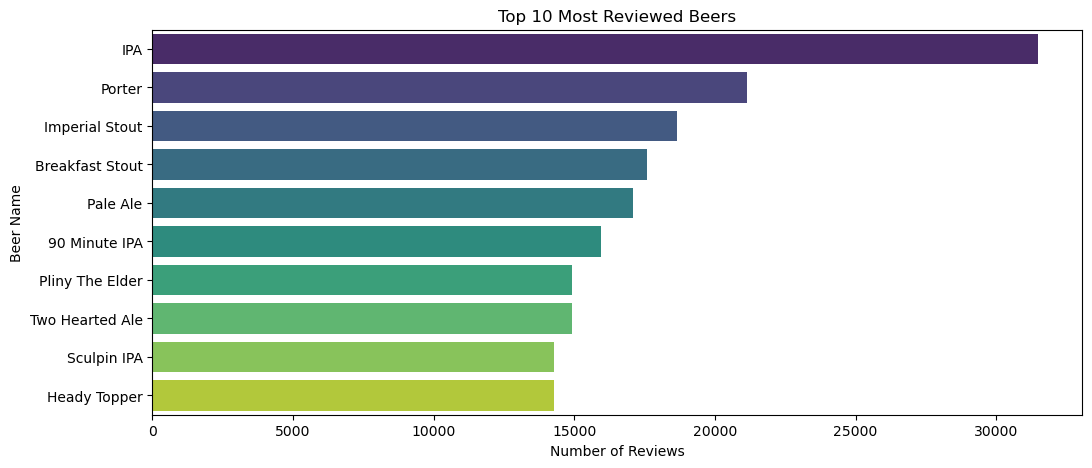

C:\Users\ixxed\AppData\Local\Temp\ipykernel_19612\3452997471.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_styles.index, x=top_styles.values, palette="coolwarm")


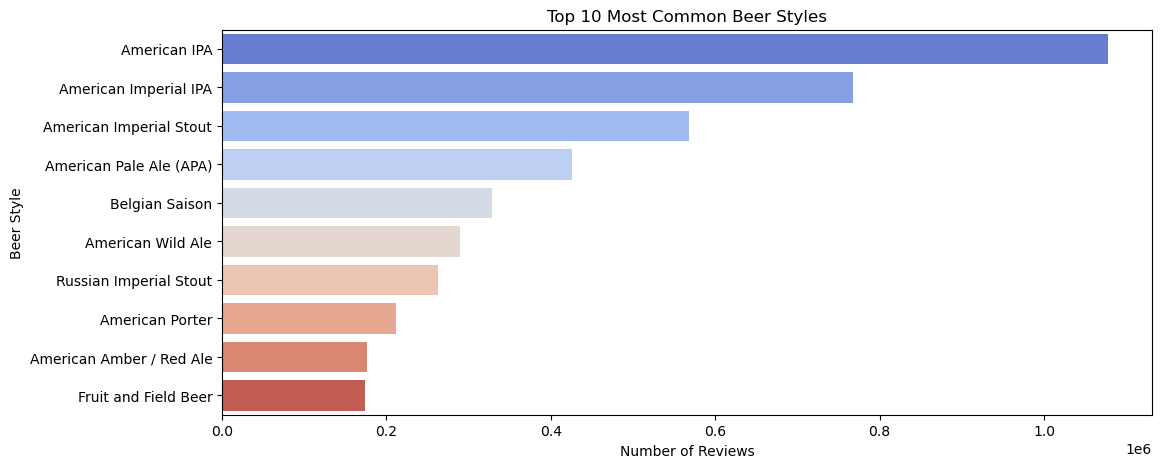

In [18]:
top_beers = beer_reviews_data['name'].value_counts().head(10)
top_styles = beer_reviews_data['style'].value_counts().head(10)
top_breweries = beer_reviews_data['brewery_name'].value_counts().head(10)

# Plot Most Popular Beers
plt.figure(figsize=(12, 5))
sns.barplot(y=top_beers.index, x=top_beers.values, palette="viridis")
plt.xlabel("Number of Reviews")
plt.ylabel("Beer Name")
plt.title("Top 10 Most Reviewed Beers")
plt.show()

# Plot Most Popular Styles
plt.figure(figsize=(12, 5))
sns.barplot(y=top_styles.index, x=top_styles.values, palette="coolwarm")
plt.xlabel("Number of Reviews")
plt.ylabel("Beer Style")
plt.title("Top 10 Most Common Beer Styles")
plt.show()

---

## Alcohol Content vs. Beer Ratings

A scatter plot was generated to visualize the relationship between a beer’s alcohol by volume (ABV) and its average user rating (`score`).

### Key Observations:
- **Concentration at Lower ABV**: Most beers in the dataset fall within the 0%–20% ABV range, which aligns with typical commercial brewing practices.
- **Sparse High-ABV Entries**: A small number of beers exhibit unusually high ABV values (above 40%), which may be outliers or non-standard entries.
- **No Strong Correlation**: Visually, there is no clear linear or monotonic relationship between ABV and user ratings. Highly rated beers are present across the full ABV spectrum.
- **Potential Outliers**: Extremely high ABV values (above 60%) may warrant further inspection or removal in downstream analyses.

This chart suggests that while ABV is an important beer attribute, it does not strongly influence overall user ratings in isolation.

## Distribution of Beer Ratings

The distribution of beer rating scores was visualized using a histogram with kernel density estimation (KDE) overlay.

### Key Observations:
- **Rating Bias Toward Higher Scores**: The distribution is right-skewed, with the majority of reviews falling between scores of **3.5 and 4.5**, peaking sharply at **4.0**.
- **Sparse Low Ratings**: Ratings below 3.0 are relatively rare, indicating that users are generally lenient or that poor-quality beers receive fewer reviews.
- **Multi-Modal Structure**: The KDE line reveals subtle peaks within the high-score range, potentially reflecting user rating tendencies influenced by platform behavior or cultural biases (e.g., favoring round numbers like 4.0 or 4.5).

This non-uniform distribution suggests that models trained on this data may benefit from rating normalization or weighting schemes to account for class imbalance.



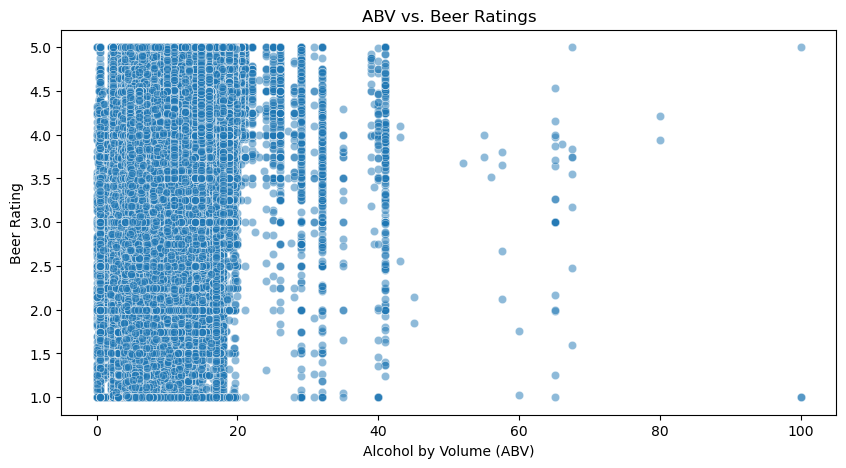

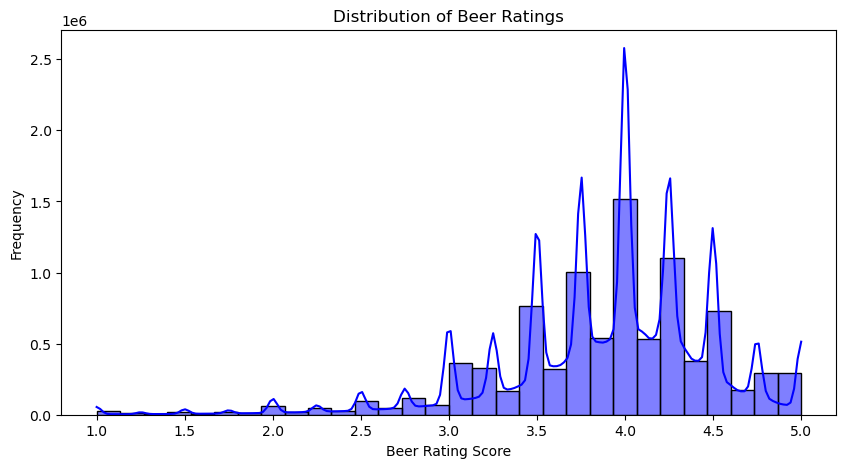

In [19]:
# ABV vs. Ratings Analysis
plt.figure(figsize=(10, 5))
sns.scatterplot(x=beer_reviews_data['abv'], y=beer_reviews_data['score'], alpha=0.5)
plt.xlabel("Alcohol by Volume (ABV)")
plt.ylabel("Beer Rating")
plt.title("ABV vs. Beer Ratings")
plt.show()

# Distribution of Beer Ratings -----------------
plt.figure(figsize=(10, 5))
sns.histplot(beer_reviews_data['score'], bins=30, kde=True, color="blue")
plt.xlabel("Beer Rating Score")
plt.ylabel("Frequency")
plt.title("Distribution of Beer Ratings")
plt.show()

---

## User Rating Behavior

The chart above highlights the top 10 most active users based on the number of beer reviews submitted.

### Key Observations:
- **Heavy Review Concentration**: A small number of users contribute disproportionately to the dataset. For example, the user *Sammy* submitted nearly 14,000 reviews, significantly more than the others.
- **Long Tail Effect**: While these top users are highly active, they represent a small fraction of the overall user base, reflecting a typical long-tail distribution commonly observed in user-generated content


C:\Users\ixxed\AppData\Local\Temp\ipykernel_19612\2672559697.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_users.index, x=top_users.values, palette="magma")


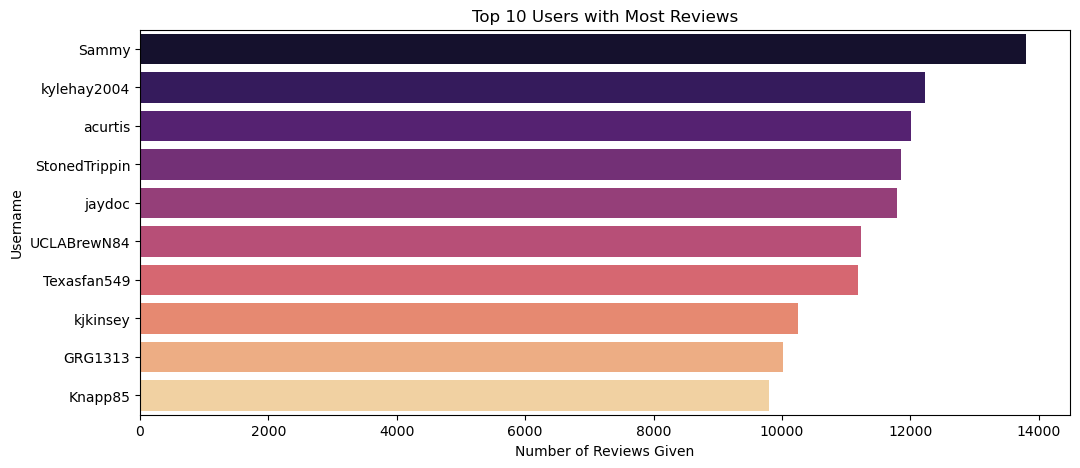

In [20]:
# User Rating Behavior 
top_users = beer_reviews_data['username'].value_counts().head(10)

plt.figure(figsize=(12, 5))
sns.barplot(y=top_users.index, x=top_users.values, palette="magma")
plt.xlabel("Number of Reviews Given")
plt.ylabel("Username")
plt.title("Top 10 Users with Most Reviews")
plt.show()

---

---

## Data Cleaning and Merging

Before building any recommendation models, it is essential to ensure the data is complete, consistent, and well-structured. This section focuses on cleaning each dataset by removing duplicates, handling missing values, encoding categorical variables, and normalizing numeric features.

Once cleaned, the datasets (`beers`, `breweries`, and `reviews`) are merged to form a unified dataset that captures both product metadata and user interactions. This merged dataset will serve as the foundation for all downstream modeling tasks, including collaborative and content-based recommendation systems.


In [55]:
import pandas as pd

# File paths
beers_file = "beers.csv"
breweries_file = "breweries.csv"
reviews_file = "reviews.csv"

# Load Beers Data
try:
    beers = pd.read_csv(beers_file, encoding="utf-8", low_memory=False)
    print("\nBeers Data Sample:")
    print(beers.head())
except Exception as e:
    print(f"Error loading beers.csv: {e}")

# Load Breweries Data
try:
    breweries = pd.read_csv(breweries_file, encoding="utf-8", low_memory=False)
    print("\nBreweries Data Sample:")
    print(breweries.head())
except Exception as e:
    print(f"Error loading breweries.csv: {e}")

# Load Reviews Data
try:
    reviews = pd.read_csv(reviews_file, encoding="utf-8", low_memory=False)
    print("\nReviews Data Sample:")
    print(reviews.head())
except Exception as e:
    print(f"Error loading reviews.csv: {e}")




Beers Data Sample:
       id                                  name  brewery_id state country  \
0  202522                        Olde Cogitator        2199    CA      US   
1   82352  Konrads Stout Russian Imperial Stout       18604   NaN      NO   
2  214879                        Scottish Right       44306    IN      US   
3  320009               MegaMeow Imperial Stout        4378    WA      US   
4  246438                       Peaches-N-Cream       44617    PA      US   

                     style availability   abv                   notes retired  
0    English Oatmeal Stout     Rotating   7.3  No notes at this time.       f  
1   Russian Imperial Stout     Rotating  10.4  No notes at this time.       f  
2             Scottish Ale   Year-round   4.0  No notes at this time.       t  
3  American Imperial Stout       Winter   8.7    Every time this year       f  
4       American Cream Ale     Rotating   5.1  No notes at this time.       f  

Breweries Data Sample:
      id     

### Filtering Invalid or Outlier Beers

To ensure data quality and remove unrepresentative entries, a set of filtering rules was applied to the original `beers` dataset:

- **Missing Values**: Beers with null values in either the `abv` (Alcohol by Volume) or `notes` fields were excluded.
- **Extreme ABV Values**: Beers with ABV greater than 20% were removed to eliminate unrealistic or rare outliers, as most commercial beers fall well below this threshold.
- **Retired Products**: Beers marked as retired (`retired = 't'`) were excluded to ensure recommendations focus on currently available products.

After filtering, the `beers_clean` DataFrame contains **222,633 valid beer entries**, offering a cleaner foundation for merging with review data and building models.


In [56]:
# Drop beers with null abv and notes. Drop beers with abv more than 20. Drop retired beers
beers_clean = beers.dropna(subset=['abv', 'notes'])
beers_clean = beers_clean[(beers_clean['abv'] < 20) & (beers_clean['retired'] != 't')]
beers_clean.count()

id              222633
name            222633
brewery_id      222633
state           179579
country         222533
style           222633
availability    222633
abv             222633
notes           222633
retired         222633
dtype: int64

---
### Cleaning Beer Reviews

The `reviews.csv` file initially contained over 9 million entries, but many reviews were incomplete. Only ~5.2 million had full tasting scores (`look`, `smell`, `taste`, `feel`, `overall`). To focus on high-quality feedback:

- We dropped rows with missing values in any of the core rating fields or empty `username` values.
- Blank review texts were also removed.

After this filtering, **2.82 million reviews** remained with complete scoring and non-empty review text.



In [57]:
# Filter out reviews with null values of tasting features and username
reviews_clean = reviews.dropna(subset=['text','look', 'smell', 'taste', 'feel', 'overall','username'])
reviews_clean = reviews_clean[reviews_clean['text'].str.strip() != '']
reviews_clean.count()

beer_id     2822616
username    2822616
date        2822616
text        2822616
look        2822616
smell       2822616
taste       2822616
feel        2822616
overall     2822616
score       2822616
dtype: int64

---

### Merging Beers and Reviews

We performed an **inner join** between the cleaned beers and reviews using the `beer_id`. This step ensured we only retained reviews for beers that passed the quality filter. The resulting merged dataset contained:

- ~2.24 million high-quality reviews
- All entries had full beer metadata and user rating information



In [58]:
# inner join of reviews and beers
merged_reviews = beers_clean.merge(reviews_clean, left_on='id', right_on='beer_id', how='inner')
merged_reviews = merged_reviews.drop(columns=['id'])
merged_reviews.count()

name            2239411
brewery_id      2239411
state           1827350
country         2236714
style           2239411
availability    2239411
abv             2239411
notes           2239411
retired         2239411
beer_id         2239411
username        2239411
date            2239411
text            2239411
look            2239411
smell           2239411
taste           2239411
feel            2239411
overall         2239411
score           2239411
dtype: int64

---

### Filtering Active Users and Popular Beers

To improve the robustness of collaborative filtering:

1. **Users with fewer than 10 reviews** were excluded.  
   This step helps ensure each user vector in the collaborative model is well-formed and not overly sparse.  
   Resulting reviews: **~2.08 million**

2. **Top 500 most reviewed beers** were selected.  
   This reduces computational load and focuses modeling on beers with the most training signals.  
   Resulting reviews: **614,525**



In [59]:
# Count reviews per user. Exclude NaN values and empty strings before counting. Get users with more than 10 reviews
user_review_counts = merged_reviews['username'].value_counts()
users_with_10plus_reviews = user_review_counts[user_review_counts > 10].index
filtered_reviews = merged_reviews[merged_reviews['username'].isin(users_with_10plus_reviews)]
print("Reviews from users with more than 10 reviews: ")
filtered_reviews.count()

Reviews from users with more than 10 reviews: 


name            2085682
brewery_id      2085682
state           1695503
country         2083153
style           2085682
availability    2085682
abv             2085682
notes           2085682
retired         2085682
beer_id         2085682
username        2085682
date            2085682
text            2085682
look            2085682
smell           2085682
taste           2085682
feel            2085682
overall         2085682
score           2085682
dtype: int64

---

### Enriching with Brewery Information

Finally, we joined the filtered reviews with brewery metadata using the `brewery_id`. This added brewery name, city, and type information to each record. After the join:

- All 614,525 reviews retained
- Additional features like `name_brewery`, `city`, and `types` were included for possible future content-based features

This finalized dataset is now balanced between beer variety, user activity, and rating completeness — ideal for both collaborative and content-based recommender models.

In [60]:
# Count reviews per beer. Get the top 500 beer IDs with most reviews
beer_review_counts = filtered_reviews['beer_id'].value_counts()
top_500_beers = beer_review_counts.nlargest(500).index
top_500_beers_reviews = filtered_reviews[filtered_reviews['beer_id'].isin(top_500_beers)]
print("Top 500 most reviewed beers: ")
top_500_beers_reviews.count()

Top 500 most reviewed beers: 


name            614525
brewery_id      614525
state           503993
country         614525
style           614525
availability    614525
abv             614525
notes           614525
retired         614525
beer_id         614525
username        614525
date            614525
text            614525
look            614525
smell           614525
taste           614525
feel            614525
overall         614525
score           614525
dtype: int64

---

### Resolving Missing State Information

During the merging process, several reviews were found to be associated with breweries that had missing state information. To improve geographic granularity, the following steps were performed:

- A query was executed to identify all **cities and countries** associated with entries where the `state` field was missing.
- A manual **city-to-state mapping dictionary** was constructed for common international cities. This mapping leverages domain knowledge and external references to assign appropriate state or regional labels based on known brewery locations.
  - For instance:
    - `Kelheim`, `München`, and `Aying` were mapped to `"Bavaria"`.
    - `Leuven`, `Hoegaarden`, and `Vlezenbeek` were mapped to `"Flemish Brabant"`.
    - `Mexico City` was mapped to itself as a federal entity.

By enriching the `state` column using this mapping, the dataset gains improved location fidelity, which can support regional-level analysis or be used as a feature in recommendation models.


In [64]:
# Get cities and countries of misisng reviews with missing states
print(beer_reviews_with_breweries[beer_reviews_with_breweries['state'].isna()]['city'].unique())
print(beer_reviews_with_breweries[beer_reviews_with_breweries['state'].isna()]['country'].unique())

['Kelheim' 'München' 'Villers-devant-Orval' 'Aying' 'Ertvelde'
 'Monterrey (Nuevo León)' 'Mexico City' 'Zoeterwoude' 'Hoegaarden'
 'Leuven' 'Westvleteren' 'Plzeň' 'Cork' 'Vlezenbeek' 'Buggenhout'
 'Rochefort' 'Malle' 'Dublin' 'Baileux (Chimay)' 'Roeselare' 'Kingston'
 'Watou' 'Beersel' 'Breendonk-Puurs' 'Freising' 'Bamberg' 'Vorchdorf'
 'Warstein' 'Oostvleteren' 'Biyagama' 'Melle' 'Berkel-Enschot' 'Brussels'
 'Bitburg/Eifel' 'Tourpes' 'Vichte' 'Bad Köstritz/Thüringen' 'Roma'
 'Achouffe' 'Dinant' 'Erding' 'Soy' 'Ceske Budejovice' 'Mechelen'
 'København']
['DE' 'BE' 'MX' 'NL' 'CZ' 'IE' 'JM' 'AT' 'LK' 'IT' 'DK']


In [65]:
# mapping missing states from cities
city_state_mapping = {
    'Kelheim': 'Bavaria',
    'München': 'Bavaria',
    'Villers-devant-Orval': 'Luxembourg Province',
    'Aying': 'Bavaria',
    'Ertvelde': 'East Flanders',
    'Monterrey (Nuevo León)': 'Nuevo León',
    'Mexico City': 'Mexico City',
    'Zoeterwoude': 'South Holland',
    'Hoegaarden': 'Flemish Brabant',
    'Leuven': 'Flemish Brabant',
    'Westvleteren': 'West Flanders',
    'Plzeň': 'Plzeň Region',
    'Cork': 'County Cork',
    'Vlezenbeek': 'Flemish Brabant',
    'Buggenhout': 'East Flanders',
    'Rochefort': 'Namur',
    'Malle': 'Antwerp',
    'Dublin': 'County Dublin',
    'Baileux (Chimay)': 'Hainaut',
    'Roeselare': 'West Flanders',
    'Kingston': 'Kingston Parish',
    'Watou': 'West Flanders',
    'Beersel': 'Flemish Brabant',
    'Breendonk-Puurs': 'Antwerp',
    'Freising': 'Bavaria',
    'Bamberg': 'Bavaria',
    'Vorchdorf': 'Upper Austria',
    'Warstein': 'North Rhine-Westphalia',
    'Oostvleteren': 'West Flanders',
    'Biyagama': 'Western Province',
    'Melle': 'East Flanders',
    'Berkel-Enschot': 'North Brabant',
    'Brussels': 'Brussels-Capital Region',
    'Bitburg/Eifel': 'Rhineland-Palatinate',
    'Tourpes': 'Hainaut',
    'Vichte': 'West Flanders',
    'Bad Köstritz/Thüringen': 'Thuringia',
    'Roma': 'Lazio',
    'Achouffe': 'Luxembourg Province',
    'Dinant': 'Namur',
    'Erding': 'Bavaria',
    'Soy': 'Wallonia',
    'Ceske Budejovice': 'South Bohemian Region',
    'Mechelen': 'Antwerp',
    'København': 'Capital Region'
}

---

### Final Imputation and Cleanup

To ensure completeness in geographical data, remaining null values in the `state` field were imputed using the previously defined `city_state_mapping`:

- **Conditional Imputation**: A row-wise function was applied where any missing `state` value was replaced with its mapped equivalent based on the `city` field. If no mapping existed, the original (possibly null) value was retained.
- **Result**: This step successfully resolved all missing `state` values, bringing the dataset to full completeness across all fields.

Following imputation, two columns were dropped:
- `retired`: Previously used for filtering but no longer needed for modeling.
- `brewery_id`: Redundant after the dataset was enriched with detailed brewery information.

The resulting `final_beers_reviews_breweries` DataFrame contains **614,525 fully enriched and cleaned entries**, ready for downstream modeling tasks such as collaborative filtering and hybrid recommender development.


In [67]:
# impute state values from city_state_mapping to all records if state is null
beer_reviews_with_breweries['state'] = beer_reviews_with_breweries.apply(
    lambda row: (
        city_state_mapping.get(row['city'], row['state'])
        if pd.isna(row['state']) else row['state']
    ),
    axis=1
)
beer_reviews_with_breweries.count()

# drop any redundant columns
final_beers_reviews_breweries = beer_reviews_with_breweries.drop(columns=['retired', 'brewery_id'])
final_beers_reviews_breweries.count()

name             614525
state            614525
country          614525
style            614525
availability     614525
abv              614525
notes            614525
beer_id          614525
username         614525
date             614525
text             614525
look             614525
smell            614525
taste            614525
feel             614525
overall          614525
score            614525
name_brewery     614525
city             614525
notes_brewery    614525
types            614525
dtype: int64

---

### Exporting the Final Dataset

The fully cleaned and enriched dataset was exported to a CSV file named `final_beers_reviews_breweries.csv` for reuse in modeling pipelines or external applications.

- **Data Structure**: The saved dataset includes 21 features per record, combining beer attributes, user reviews, and brewery information.
- **Verification**: A sample was reloaded from the CSV file and displayed to confirm successful export. The sample includes entries for the beer *Older Viscosity*, a highly rated American Imperial Stout brewed by *Port Brewing* in San Marcos, CA.

This finalized dataset is now ready to be used in model training, evaluation, and hybrid recommendation system development.


In [70]:
final_beers_reviews_breweries.to_csv('final_beers_reviews_breweries.csv', index=False)

try:
    final = pd.read_csv('final_beers_reviews_breweries.csv')
    print("\final Data Sample:")
    print(final.head())
except Exception as e:
    print(f"Error loading reviews.csv: {e}")

inal Data Sample:
              name state country                    style availability   abv  \
0  Older Viscosity    CA      US  American Imperial Stout     Rotating  12.0   
1  Older Viscosity    CA      US  American Imperial Stout     Rotating  12.0   
2  Older Viscosity    CA      US  American Imperial Stout     Rotating  12.0   
3  Older Viscosity    CA      US  American Imperial Stout     Rotating  12.0   
4  Older Viscosity    CA      US  American Imperial Stout     Rotating  12.0   

                                               notes  beer_id     username  \
0  Imperial Stout aged for 12 months in new bourb...    34094        Sazz9   
1  Imperial Stout aged for 12 months in new bourb...    34094  Amguerra305   
2  Imperial Stout aged for 12 months in new bourb...    34094      TheGent   
3  Imperial Stout aged for 12 months in new bourb...    34094         bobv   
4  Imperial Stout aged for 12 months in new bourb...    34094      Tony210   

         date  ...  look  smell

---

### Final Dataset Validation

After saving and reloading the processed dataset from `final_beers_reviews_breweries.csv`, a comprehensive integrity check was performed to confirm data quality.

#### Dataset Overview:
- The dataset contains **614,525 entries** and **21 columns**, including beer characteristics, user review scores, and brewery metadata.
- All data types are correctly inferred: numeric columns (e.g., `abv`, `score`), categorical fields (e.g., `style`, `types`), and text columns (e.g., `notes`, `text`).

#### Statistical Summary:
- **Alcohol by Volume (ABV)**: Ranges from 2.5% to 18%, with a mean of approximately 7.58%.
- **Review Scores**: Tasting attributes (`look`, `smell`, `taste`, `feel`, `overall`) all average close to **4.0**, with `score` showing a similar central tendency and mild right skew.
- **Beer ID Range**: Spans from 6 to 148,052, confirming diverse beer entries across the dataset.

#### Completeness:
- **No missing values** are present across any columns, confirming that imputation and data integration steps were successfully executed.

This final validation confirms the dataset is clean, comprehensive, and ready for model training and evaluation.


In [71]:
# Basic Data Info
print("Dataset Overview:")
print(final.info())

print("\nSummary Statistics:")
print(final.describe())

print("\nMissing Values:")
print(final.isnull().sum())

Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614525 entries, 0 to 614524
Data columns (total 21 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   name           614525 non-null  object 
 1   state          614525 non-null  object 
 2   country        614525 non-null  object 
 3   style          614525 non-null  object 
 4   availability   614525 non-null  object 
 5   abv            614525 non-null  float64
 6   notes          614525 non-null  object 
 7   beer_id        614525 non-null  int64  
 8   username       614525 non-null  object 
 9   date           614525 non-null  object 
 10  text           614525 non-null  object 
 11  look           614525 non-null  float64
 12  smell          614525 non-null  float64
 13  taste          614525 non-null  float64
 14  feel           614525 non-null  float64
 15  overall        614525 non-null  float64
 16  score          614525 non-null  float64
 17  name_brewer

---

## Conclusion of Data Exploration

The data exploration and preprocessing phase successfully prepared a robust and high-quality dataset for downstream modeling tasks. Key accomplishments include:

- Cleaning and standardizing multiple datasets (`beers.csv`, `breweries.csv`, `reviews.csv`) through deduplication, null handling, and feature encoding.
- Merging beer, review, and brewery metadata into a single, comprehensive dataset.
- Imputing missing geographic fields and filtering for high-quality, high-density user-review data.
- Identifying key statistical patterns and ensuring complete data coverage with no missing values.

With a validated and enriched dataset of over **614,000 reviews**, the groundwork is now complete for developing and evaluating various recommender system models, including collaborative filtering and content-based approaches.
